In [81]:
import os
import datetime as dt

import random as python_random

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,4
plt.style.use('ggplot')

import numpy as np
import pandas as pd

import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization,Input,Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [82]:
#PARAMETERS
EPOCHS=30
BATCH_SIZE=512
RANDOMSEED=123
SELECTED_STOCK='GME'

In [83]:
np.random.seed(RANDOMSEED)
python_random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

<AxesSubplot:xlabel='Date'>

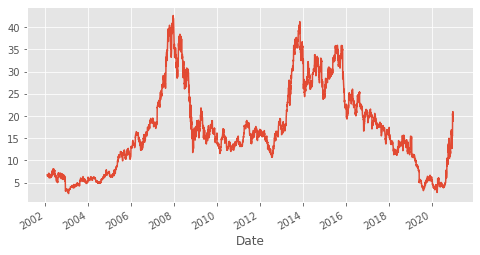

In [84]:
stock=yf.Ticker(SELECTED_STOCK).history(start='2000-01-01',end='2021-01-01')
msft=yf.Ticker('MSFT').history(start='2000-01-01',end='2021-01-01')
stock.Close.plot()

In [85]:
class Dataset():
  def __init__(self, data, target='Close',scale=True,look_forw=1,look_back=20,test_size=0.2):
    #Store the raw data.    
    self.split=int(len(data)*(1-test_size))
    self.Scaler=None
    self.target_col=data.columns.get_loc(target)
    self.look_forw = look_forw
    self.look_back=look_back
    self.train_dates=data.iloc[:self.split,:].index
    self.test_dates=data.iloc[self.split-self.look_back:,:].index

    #self.Data=data.dropna(subset=['Close'],how='any')   

    self.Train = np.array(data.iloc[:self.split,:])
    self.Test = np.array(data.iloc[self.split-self.look_back:,:])

    if scale==True:
      self.Scaler=MinMaxScaler(feature_range = (0, 1))
      self.Scaler=self.Scaler.fit(self.Train)
    
      self.Train=self.Scaler.transform(self.Train)
      self.Test=self.Scaler.transform(self.Test)
     
    self.X_train_seq=[]
    self.y_train_seq=[]
    for i in range(self.look_back,len(self.Train)):
            self.X_train_seq.append(self.Train[i-self.look_back:i,:])
            self.y_train_seq.append(self.Train[i,self.target_col])

    self.X_train_seq=np.array(self.X_train_seq)
    self.y_train_seq=np.array(self.y_train_seq)

    self.X_train_seq=self.X_train_seq.reshape(self.X_train_seq.shape[0],self.X_train_seq.shape[1],self.X_train_seq.shape[2])

    self.X_test_seq=[]
    for i in range(self.look_back,len(self.Test)):
            self.X_test_seq.append(self.Test[i-self.look_back:i,:])
            
    self.X_test_seq=np.asarray(self.X_test_seq)
    self.X_test_seq=self.X_test_seq.reshape(self.X_test_seq.shape[0],self.X_test_seq.shape[1],self.X_test_seq.shape[2])

    print(self.__repr__())

  def __repr__(self):
    return '\n'.join([
    f'Original train and test{self.Train.shape,self.Test.shape}',
    f'X train size {self.X_train_seq.shape}',
    f'Y train size: {self.y_train_seq.shape}',
    f'X test size: {self.X_test_seq.shape}'])

In [86]:
short_data=Dataset(stock,look_back=20)
med_data=Dataset(stock,look_back=60)
long_data=Dataset(stock,look_back=120)

Original train and test((3804, 7), (971, 7))
X train size (3784, 20, 7)
Y train size: (3784,)
X test size: (951, 20, 7)
Original train and test((3804, 7), (1011, 7))
X train size (3744, 60, 7)
Y train size: (3744,)
X test size: (951, 60, 7)
Original train and test((3804, 7), (1071, 7))
X train size (3684, 120, 7)
Y train size: (3684,)
X test size: (951, 120, 7)


In [87]:
def Shallow_LSTM_model(input_shape,neurons):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=neurons, return_sequences=True,input_shape=input_shape))
    lstm_model.add(LSTM(units=neurons, return_sequences=False))
    lstm_model.add(Dense(units=1,activation='linear'))
        
    
    defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
    lstm_model.compile(optimizer=optimizer, loss='mse',metrics=defined_metrics)
    
    return lstm_model

In [88]:
def Deep_LSTM_model(input_shape,neurons):
    lstm_model = Sequential()
    lstm_model.add(LSTM(neurons, return_sequences=True,input_shape=input_shape))
    lstm_model.add(LSTM(neurons, return_sequences=False))
    lstm_model.add(LSTM(neurons, return_sequences=False))
    lstm_model.add(LSTM(neurons, return_sequences=False))
    lstm_model.add(Dense(1,activation='linear'))
        
    
    defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
    lstm_model.compile(optimizer=optimizer, loss='mae',metrics=defined_metrics)
    
    return lstm_model

In [89]:
keras.backend.clear_session()
short_shallow_lstm=Shallow_LSTM_model(input_shape=(short_data.look_back,short_data.X_train_seq.shape[2]),neurons=10)

es=EarlyStopping(monitor='val_loss',min_delta=1e-10,patience=10,verbose=1)
rlr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,verbose=1)
mcp=ModelCheckpoint(filepath='weights.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
tb=TensorBoard('logs')

short_shallow_lstm.fit(short_data.X_train_seq,short_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

In [90]:
keras.backend.clear_session()
med_shallow_lstm=Shallow_LSTM_model(input_shape=(med_data.look_back,med_data.X_train_seq.shape[2]),neurons=10)

med_shallow_lstm.fit(med_data.X_train_seq,med_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

In [91]:
keras.backend.clear_session()
long_shallow_lstm=Shallow_LSTM_model(input_shape=(long_data.look_back,long_data.X_train_seq.shape[2]),neurons=10)

long_shallow_lstm.fit(long_data.X_train_seq,long_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.2)

In [92]:
keras.backend.clear_session()
long_deep_lstm=Shallow_LSTM_model(input_shape=(long_data.look_back,long_data.X_train_seq.shape[2]),neurons=50)

long_deep_lstm.fit(long_data.X_train_seq,long_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=int(BATCH_SIZE/2),
                shuffle=False,
                verbose=0,
                validation_split=0.2)

In [93]:
if short_data.Scaler==None:
    short=short_shallow_lstm.predict(short_data.X_test_seq)
    med=med_shallow_lstm.predict(med_data.X_test_seq)
    long=long_shallow_lstm.predict(long_data.X_test_seq)
    long_deep=long_deep_lstm.predict(long_data.X_test_seq)
    
else:
    short_preds=np.repeat(short_shallow_lstm.predict(short_data.X_test_seq),7,axis=1)
    med_preds=np.repeat(med_shallow_lstm.predict(med_data.X_test_seq),7,axis=1)
    long_preds=np.repeat(long_shallow_lstm.predict(long_data.X_test_seq),7,axis=1)
    long_preds_deep=np.repeat(long_deep_lstm.predict(long_data.X_test_seq),7,axis=1)
    
    short=short_data.Scaler.inverse_transform(short_preds)[:,0]
    med=med_data.Scaler.inverse_transform(med_preds)[:,0]
    long=long_data.Scaler.inverse_transform(long_preds)[:,0]
    long_deep=long_data.Scaler.inverse_transform(long_preds_deep)[:,0]

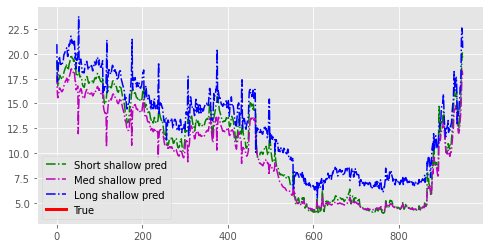

In [119]:
cut=-1
plt.plot(short[:cut],'g-.',label='Short shallow pred')
plt.plot(med[:cut],'m-.',label='Med shallow pred')
plt.plot(long[:cut],'b-.',label='Long shallow pred')
#plt.plot(long_deep,label='Long deep pred')
plt.plot(stock.Close[long_data.split:long_data.split+cut].values,'r',label='True',linewidth=3)
plt.legend() 
plt.show()

In [95]:
msft_data=Dataset(msft,look_back=short_data.look_back)

Original train and test((4228, 7), (1077, 7))
X train size (4208, 20, 7)
Y train size: (4208,)
X test size: (1057, 20, 7)


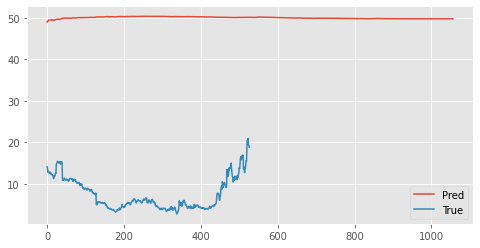

In [96]:
msft_preds=np.repeat(short_shallow_lstm.predict(msft_data.X_test_seq),7,axis=1)
msft_preds=msft_data.Scaler.inverse_transform(msft_preds)[:,0]

plt.plot(msft_preds,label='Pred')
plt.plot(stock.Close[msft_data.split:].values,label='True')
plt.legend() 
plt.show()